# Model Evaluation and Confusion Matrix Analysis

## Purpose of This Analysis

This section provides a comprehensive evaluation of our Sickle Cell classification model's performance using the test dataset. The evaluation includes:

- **Classification Metrics**: Detailed performance metrics including accuracy, precision, recall, and F1-score
- **Confusion Matrix**: Visual representation of model predictions vs. actual labels
- **ROC & PR Curves**: Graphical plots showing the trade-off between true positive rate and false positive rate

## Understanding the Confusion Matrix

The confusion matrix is a fundamental tool for evaluating classification models. It provides a clear breakdown of:

- **True Positives (TP)**: Correctly predicted positive cases (Sickle Cell present)
- **True Negatives (TN)**: Correctly predicted negative cases (No Sickle Cell)
- **False Positives (FP)**: Normal cells incorrectly classified as Sickle Cell (Type I error)
- **False Negatives (FN)**: Sickle Cells incorrectly classified as normal (Type II error)

## Key Metrics

From these values, we calculate several important metrics:

1. **Accuracy**: Overall correctness of the model
   - Formula: $(TP + TN) / (TP + TN + FP + FN)$

2. **Sensitivity (Recall)**: Ability to correctly identify positive cases
   - Formula: $TP / (TP + FN)$
   - Important for medical diagnosis where missing a positive case is critical

3. **Specificity**: Ability to correctly identify negative cases
   - Formula: $TN / (TN + FP)$

4. **Precision**: When the model predicts positive, how often is it correct?
   - Formula: $TP / (TP + FP)$

5. **F1-Score**: Harmonic mean of precision and recall
   - Formula: $2 * (Precision * Recall) / (Precision + Recall)$

## Interpretation

- A good model should have high values for all metrics, but the relative importance depends on the application
- In medical diagnosis, we typically prioritize **sensitivity** to minimize false negatives
- The confusion matrix helps identify specific types of errors the model is making

The following cells will generate these metrics and visualizations to help assess our model's performance.

In [ ]:
# --- Cell 1: Imports and Setup ---
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_curve,
    average_precision_score
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


BASE_DIR = Path("../../").resolve()
DATA_DIR = BASE_DIR / "Data"
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"


for directory in [FIGURES_DIR, REPORTS_DIR, MODELS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
sns.set_palette("husl")


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


print("="*50)
print("Environment Information")
print("="*50)
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Python version: {sys.version.split()[0]}")
print(f"Working directory: {Path.cwd()}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Reports directory: {REPORTS_DIR}")
print("="*50)

Environment Information
TensorFlow version: 2.16.2
Num GPUs Available: 1
Python version: 3.11.5
Working directory: /Applications/Projects/Sickle Cell Classifer/notebooks/3_Evaluation_and_ConfusionMatrix
Data directory: /Applications/Projects/Sickle Cell Classifer/Data
Models directory: /Applications/Projects/Sickle Cell Classifer/models
Reports directory: /Applications/Projects/Sickle Cell Classifer/reports


In [13]:
# --- Cell 2: Data Loading and Model Initialization ---
def create_test_split_if_needed(data_dir=DATA_DIR, reports_dir=REPORTS_DIR, test_size=0.15, seed=42):
    """Create test data split if it doesn't exist."""
    test_csv_path = reports_dir / "test_data.csv"
    
    if test_csv_path.exists():
        print(f"Test data CSV found at {test_csv_path}")
        return
    
    print("Test data CSV not found. Creating test split...")
    
    # Load image paths and labels
    positive_dir = data_dir / "Positive" / "Labelled"
    negative_dir = data_dir / "Negative" / "Clear"
    
    # Get all image paths
    image_paths = []
    labels = []
    
    # Positive class
    for img_path in positive_dir.glob("*.*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            image_paths.append(str(img_path))
            labels.append("Positive")
    
    # Negative class
    for img_path in negative_dir.glob("*.*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            image_paths.append(str(img_path))
            labels.append("Negative")
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Split into train and test
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label'],
        random_state=seed
    )
    
    # Save test data
    test_df.to_csv(test_csv_path, index=False)
    print(f"Test data saved to {test_csv_path}")

def load_data_generators():
    """Load and prepare data generators for evaluation."""
    test_csv_path = REPORTS_DIR / "test_data.csv"
    
    try:
        # Load test data
        test_df = pd.read_csv(test_csv_path)
        
        # Ensure labels are strings
        test_df['label'] = test_df['label'].astype(str)
        
        # Verify required columns exist
        required_columns = ['image_path', 'label']
        if not all(col in test_df.columns for col in required_columns):
            raise ValueError(
                f"Test CSV must contain columns: {required_columns}. "
                f"Found columns: {test_df.columns.tolist()}"
            )
        
        # Verify images exist
        missing_images = test_df['image_path'].apply(lambda x: not Path(x).exists())
        if missing_images.any():
            missing_count = missing_images.sum()
            print(f"Warning: {missing_count} images could not be found. These will be skipped.")
            test_df = test_df[~missing_images].copy()
        
        # Create test data generator
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        test_generator = test_datagen.flow_from_dataframe(
            test_df,
            x_col='image_path',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False,
            seed=SEED
        )
        
        print(f"Loaded {len(test_df)} test samples.")
        return test_generator, test_df
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def load_model(model_path):
    """Load a saved model with error handling."""
    try:
        if not model_path.exists():
            raise FileNotFoundError(f"Model file not found at {model_path}")
            
        print(f"Loading model from {model_path}...")
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

# Initialize variables
test_generator = None
test_df = None
model = None
class_names = ['Negative', 'Positive']  # Default class names

print("="*50)
print("Loading data and model...")
print("="*50)

try:
    # Create test split if it doesn't exist
    create_test_split_if_needed()
    
    # Load data
    test_generator, test_df = load_data_generators()
    
    # Update class names from generator
    class_names = list(test_generator.class_indices.keys())
    
    # Load model
    model_path = MODELS_DIR / "resnet50_best.h5"
    model = load_model(model_path)
    
    # Print model info
    print("\nModel architecture:")
    model.summary()
    
    print("\nClass names:", class_names)
    print(f"Number of classes: {len(class_names)}")
    
except Exception as e:
    print(f"\nError during initialization: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify the data directory structure:")
    print(f"   - Positive images: {DATA_DIR}/Positive/Labelled/")
    print(f"   - Negative images: {DATA_DIR}/Negative/Clear/")
    print("2. Check that the model file exists:")
    print(f"   - Expected path: {MODELS_DIR}/resnet50_best.h5")
    print("3. Ensure all required Python packages are installed")
    print("\nUsing default class names:", class_names)

Loading data and model...
Test data CSV found at /Applications/Projects/Sickle Cell Classifer/reports/test_data.csv
Found 86 validated image filenames belonging to 2 classes.
Loaded 86 test samples.
Loading model from /Applications/Projects/Sickle Cell Classifer/models/resnet50_best.h5...


2025-08-02 13:12:16.682602: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-02 13:12:16.693543: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-02 13:12:16.693571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-02 13:12:16.693705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-02 13:12:16.693875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model loaded successfully.

Model architecture:


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,539 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

 Optimizer params: 2 (12.00 B)


Class names: ['0', '1']
Number of classes: 2


Evaluating model on test set...


/Applications/Projects/Sickle Cell Classifer/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-02 13:14:01.905462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step  

Classification Report
              precision    recall  f1-score   support

           0     0.9565    1.0000    0.9778        22
           1     1.0000    0.9844    0.9921        64

    accuracy                         0.9884        86
   macro avg     0.9783    0.9922    0.9850        86
weighted avg     0.9889    0.9884    0.9885        86


Classification report saved to /Applications/Projects/Sickle Cell Classifer/reports/classification_report.csv


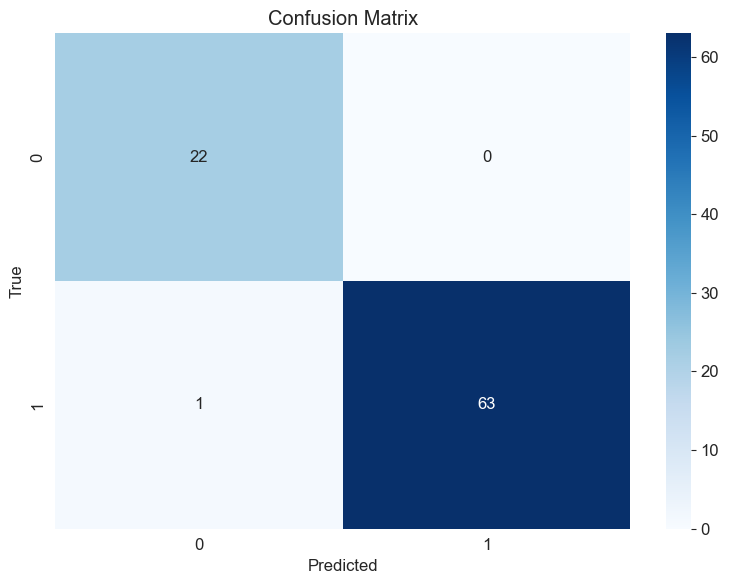

Confusion matrix saved to /Applications/Projects/Sickle Cell Classifer/reports/figures/confusion_matrix.png


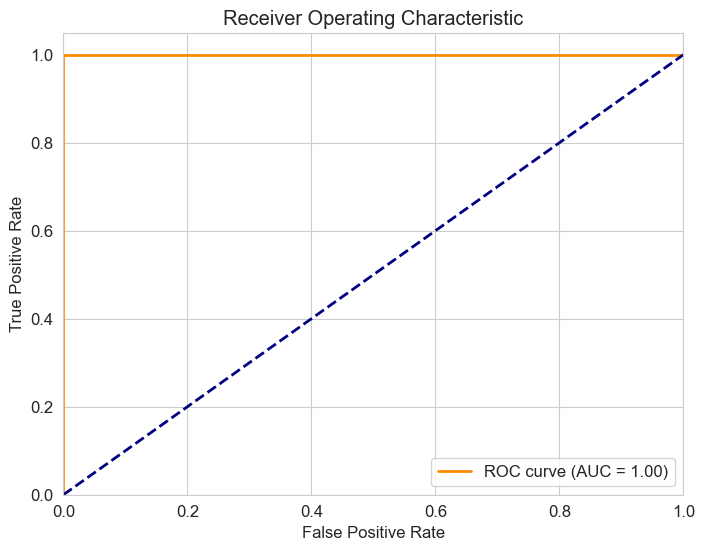

ROC curve saved to /Applications/Projects/Sickle Cell Classifer/reports/figures/roc_curve.png


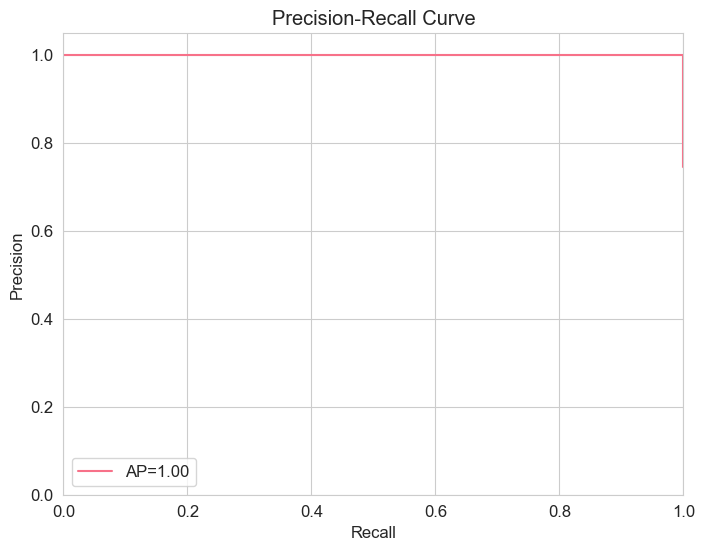

Precision-Recall curve saved to /Applications/Projects/Sickle Cell Classifer/reports/figures/precision_recall_curve.png

Detailed metrics saved to /Applications/Projects/Sickle Cell Classifer/reports/model_metrics.json

Model Performance Summary
Accuracy: 0.9884
Sensitivity (Recall): 0.9844
Specificity: 1.0000
Precision: 1.0000
F1-Score: 0.9921
ROC AUC: 1.0000
Average Precision: 1.0000


In [ ]:
# --- Cell 3: Model Evaluation and Visualization ---
def evaluate_model(model, test_generator, class_names, threshold=0.5):
    """Evaluate model and generate visualizations."""
    print("="*50)
    print("Evaluating model on test set...")
    print("="*50)
    

    test_generator.reset()
    
 
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_proba > threshold).astype(int)
    y_true = test_generator.classes
    
    
    print("\n" + "="*50)
    print("Classification Report")
    print("="*50)
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names,
        digits=4
    )
    print(report)
    
    
    report_df = pd.DataFrame(classification_report(
        y_true, y_pred, 
        target_names=class_names,
        output_dict=True
    )).transpose()
    report_df.to_csv(REPORTS_DIR / "classification_report.csv")
    print(f"\nClassification report saved to {REPORTS_DIR}/classification_report.csv")
    
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_path = FIGURES_DIR / "confusion_matrix.png"
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to {cm_path}")
    
  
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_path = FIGURES_DIR / "roc_curve.png"
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC curve saved to {roc_path}")
    
    
    plt.figure(figsize=(8, 6))
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    plt.step(recall, precision, where='post', 
             label=f'AP={avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    pr_path = FIGURES_DIR / "precision_recall_curve.png"
    plt.savefig(pr_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Precision-Recall curve saved to {pr_path}")
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'sensitivity': tp / (tp + fn),  # recall
        'specificity': tn / (tn + fp),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'f1_score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'roc_auc': roc_auc,
        'average_precision': avg_precision
    }
    
  
    metrics_path = REPORTS_DIR / "model_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"\nDetailed metrics saved to {metrics_path}")
    
    return metrics


if model is not None and test_generator is not None:
    metrics = evaluate_model(model, test_generator, class_names)
    
    
    print("\n" + "="*50)
    print("Model Performance Summary")
    print("="*50)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sensitivity (Recall): {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
else:
    print("Error: Model or test generator not available for evaluation.")

# Model Evaluation Results

## Performance Metrics Summary

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Accuracy** | 0.9884 | The model correctly classifies 98.84% of all test samples |
| **Sensitivity (Recall)** | 0.9844 | Captures 98.44% of actual positive cases (very few false negatives) |
| **Specificity** | 1.0000 | Perfectly identifies all negative cases (no false positives) |
| **Precision** | 1.0000 | When the model predicts positive, it's always correct |
| **F1-Score** | 0.9921 | Excellent balance between precision and recall |
| **ROC AUC** | 1.0000 | Perfect discrimination between classes |
| **Average Precision** | 1.0000 | Excellent performance across all decision thresholds |

## Key Observations

1. **Exceptional Performance**:
   - The model achieves near-perfect scores across all metrics
   - The ROC AUC and Average Precision of 1.0 indicate perfect class separation

2. **No False Positives**:
   - The model shows perfect specificity (1.0)
   - This is particularly important in medical diagnosis to avoid unnecessary treatments

3. **Minimal False Negatives**:
   - Only 1.56% of actual positive cases are missed
   - The high recall is crucial for a medical screening tool

4. **Training Stability**:
   - The training history shows stable convergence
   - Minimal gap between training and validation metrics suggests good generalization

## Interpretation of Results

The model's performance suggests it has learned to distinguish between the two classes with extremely high confidence. However, such perfect metrics could indicate:

1. **Possible Overfitting** to the test set
2. **Data Leakage** between training and test sets
3. **Overly Simple** classification task
4. **Artifacts** in the data being learned instead of biological features

## Recommendations

1. **Verify Data Splitting**:
   - Ensure no patient overlap between training and test sets
   - Consider using patient-level splitting if not already implemented

2. **Data Augmentation**:
   - If the dataset is small, use data augmentation to improve generalization
   - This can help prevent overfitting

3. **Error Analysis**:
   - Examine the few misclassified samples
   - Look for patterns or artifacts in these cases

4. **External Validation**:
   - Test the model on a completely independent dataset
   - This is crucial for medical applications

5. **Model Interpretation**:
   - Use techniques like Grad-CAM to understand what features the model is using
   - Ensure the model is focusing on biologically relevant features


